# HDP-base spell-sound analyzer
# developed by Kow Kuroda (kow.kuroda@gmail.com)
# History
2024/08/19 Cython を使った cy_gen_ngrams を利用可能にした
2024/09/02 n-gram 生成の generic function を導入し，コードを簡略化
2024/09/06 term の階層クラスタリングを実装

In [1]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [2]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [3]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [4]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [5]:
## Cython を使うかどうか
use_Cython = True
if use_Cython:
    %load_ext Cython

In [6]:
## term settings
term_classes        = [ 'spell', 'sound' ]
term_class          = term_classes[0]
ngram_is_inclusive  = True
inclusion_degree    = None

## doc settings
max_doc_size        = 11
min_doc_size        =  3
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

### boundary handling
mark_boundaries     = True
boundary_mark       = "#"

## term setting
term_is_skippy      = True
n_for_ngram         = 5
max_gap_ratio       = 1.0
max_gap_size        = round(max_doc_size * max_gap_ratio)
print(f"term_class: {term_class}")
print(f"term_is_skippy: {term_is_skippy}")
print(f"max_gap_size: {max_gap_size}")
print(f"n_for_ngram: {n_for_ngram}")

## symbols
gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if term_class == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")
## define term_type
if term_class == 'spell':
    if term_is_skippy:
        term_type = f"sp_skippy{n_for_ngram}gram"
    else:
        term_type = f"sp_{n_for_ngram}gram"
else:
    if term_is_skippy:
        term_type = f"sn_skippy{n_for_ngram}gram"
    else:
        term_type = f"sn_{n_for_ngram}gram"
## check
print(f"term_type: {term_type}")

max_doc_size: 11
min_doc_size: 3
term_class: spell
term_is_skippy: True
max_gap_size: 11
n_for_ngram: 5
accent_status: 
term_type: sp_skippy5gram


In [7]:
## target language
## a key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German Nouns',
                        'de_non_N_only' : 'German Non-nouns',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]
## check
target_lang_key  = target_lang_keys[11]
print(f"target_lang_key: {target_lang_key}")
print(f"target lang: {target_lang_dict[target_lang_key]} [{target_lang_key}]")

## target_attr [effective only for Irish]
target_class = ""

#target_class = None # This causes an unrediable error
if target_lang_key == "ir":
    target_classes = [ 'adjectives', 'nouns', 'verbs' ]
    target_class = f"-{target_classes[3]}"
print(f"target_class: {target_class}")

target_lang_key: es_ES
target lang: Spanish (Spain) [es_ES]
target_class: 


In [8]:
## LDA/HDP
apply_term_filtering = True
## The following parameters need to be relatively large to prevent "Row sum not equal 1" error
term_minfreq       = 2
min_bot_size       = min_doc_size # 3
abuse_threshold    = 0.05 # larger value selects shorter units, smaller value selects longer units

# number of terms listed for a given topic
n_docs_to_show     = 15
n_terms_to_show    = 20
n_terms_to_save    = 120

# saving output
save_LDAvis          = False
save_topic_structure = False

# hierarchical clustering
hc_sampling_rate = 0.01

In [9]:
## sampling
source_sampling          = True
source_sampling_rate     = 0.5
source_sampling_max_size = 5000
second_sampling          = False
second_sampling_rate     = 0.7

In [10]:
## set target files
import glob
data_dir1     = "data/open-dict-ipa/data1"
data_dir2     = "data/open-dict-ipa/data1a"
data_dir3     = "data/wn3"
data_dir4     = "data/irish"
target_files  = glob.glob(f"{data_dir1}/*")
target_files2 = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3 = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4 = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
#
target_files = sorted([ file for file in target_files if ".csv" in file ])
pp.pprint(target_files)

['data/irish/word-irish-adjectives-spell.csv',
 'data/irish/word-irish-noun-phrases-spell.csv',
 'data/irish/word-irish-nouns-spell.csv',
 'data/irish/word-irish-possessives-spell.csv',
 'data/irish/word-irish-prepositions-spell.csv',
 'data/irish/word-irish-verbs-spell.csv',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/is.csv.gz',
 'data/open-dict-ipa/data1/ja.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 '

In [11]:
## get source data from files
import pandas as pd
import gzip
#target_language_key = "en_US" # can be changed to get other languages
#if target_class != "" or target_class is not None:
if target_class != "":
    target_file = [ f for f in target_files if target_lang_key in f and target_class in f ][0]
else:
    target_file = [ f for f in target_files if target_lang_key in f ][0]
print(f"processing: {target_file}")
##
if target_lang_key == "ir":
    col_names = ['spell', 'POS']
else:
    col_names = ['spell', 'sound']

##
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

## normalize characters
raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

## modify sound
try:
    sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
    sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
    raw_df['sound'] = sounds
except (AttributeError, KeyError):
    pass
#
raw_df.sample(10)

processing: data/open-dict-ipa/data1/es_ES.csv.gz


,spell,sound
346259,gemelos,xemelos
434187,occitánica,okθiˈtanika
237033,embancaran,embaŋkaɾan
223987,dimes,dimes
131423,concursa,koŋkuɾsa
91996,binóculo,biˈnokulo
19361,adivinaría,aðiβinaˈɾia
121034,clasificando,klasifikando
517983,retrasen,retɾasen
484849,rebasaba,reβasaβa


In [12]:
## source sampling
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		raw_df = raw_df.sample(source_sampling_max_size)
	else:
		raw_df = raw_df.sample(round(len(raw_df) * source_sampling_rate))
## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                     spell               sound
210843          #despobla#          #despoβla#
385575        #jarretases#         #xaretases#
30697             #ajenos#            #axenos#
134154        #conglobare#        #koŋgloβaɾe#
368705         #incididas#         #inθiðiðas#
...                    ...                 ...
548830           #sorberá#           #soɾβeɾa#
160441  #desacreditándoos#  #desakɾeðitandoos#
591276        #viviéremos#        #biβjeɾemos#
506605      #renovándolas#      #renoβandolas#
286177      #entrapajamos#      #entɾapaxamos#

[5000 rows x 2 columns]


In [13]:
## generate 1-grams for spell and sound
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: list(str(x)))
# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
raw_df

,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
210843,#despobla#,#despoβla#,"[#, d, e, s, p, o, b, l, a, #]",10,0,0,"[#, d, e, s, p, o, β, l, a, #]",10
385575,#jarretases#,#xaretases#,"[#, j, a, r, r, e, t, a, s, e, s, #]",12,0,0,"[#, x, a, r, e, t, a, s, e, s, #]",11
30697,#ajenos#,#axenos#,"[#, a, j, e, n, o, s, #]",8,0,0,"[#, a, x, e, n, o, s, #]",8
134154,#conglobare#,#koŋgloβaɾe#,"[#, c, o, n, g, l, o, b, a, r, e, #]",12,0,0,"[#, k, o, ŋ, g, l, o, β, a, ɾ, e, #]",12
368705,#incididas#,#inθiðiðas#,"[#, i, n, c, i, d, i, d, a, s, #]",11,0,0,"[#, i, n, θ, i, ð, i, ð, a, s, #]",11
...,...,...,...,...,...,...,...,...
548830,#sorberá#,#soɾβeɾa#,"[#, s, o, r, b, e, r, á, #]",9,0,0,"[#, s, o, ɾ, β, e, ɾ, a, #]",9
160441,#desacreditándoos#,#desakɾeðitandoos#,"[#, d, e, s, a, c, r, e, d, i, t, á, n, d, o, ...",18,0,0,"[#, d, e, s, a, k, ɾ, e, ð, i, t, a, n, d, o, ...",18
591276,#viviéremos#,#biβjeɾemos#,"[#, v, i, v, i, é, r, e, m, o, s, #]",12,0,0,"[#, b, i, β, j, e, ɾ, e, m, o, s, #]",12
506605,#renovándolas#,#renoβandolas#,"[#, r, e, n, o, v, á, n, d, o, l, a, s, #]",14,0,0,"[#, r, e, n, o, β, a, n, d, o, l, a, s, #]",14


In [14]:
## filtering raw_data by size
print(f"term_type: {term_type}")
if "sp_" in term_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_type: sp_skippy5gram


,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
210843,#despobla#,#despoβla#,"[#, d, e, s, p, o, b, l, a, #]",10,0,0,"[#, d, e, s, p, o, β, l, a, #]",10
30697,#ajenos#,#axenos#,"[#, a, j, e, n, o, s, #]",8,0,0,"[#, a, x, e, n, o, s, #]",8
368705,#incididas#,#inθiðiðas#,"[#, i, n, c, i, d, i, d, a, s, #]",11,0,0,"[#, i, n, θ, i, ð, i, ð, a, s, #]",11
23906,#afligía#,#aflixia#,"[#, a, f, l, i, g, í, a, #]",9,0,0,"[#, a, f, l, i, x, i, a, #]",9
509274,#repollo#,#repoʎo#,"[#, r, e, p, o, l, l, o, #]",9,0,0,"[#, r, e, p, o, ʎ, o, #]",8
...,...,...,...,...,...,...,...,...
558135,#tapizas#,#tapiθas#,"[#, t, a, p, i, z, a, s, #]",9,0,0,"[#, t, a, p, i, θ, a, s, #]",9
6080,#absortas#,#aβsoɾtas#,"[#, a, b, s, o, r, t, a, s, #]",10,0,0,"[#, a, β, s, o, ɾ, t, a, s, #]",10
118575,#chupaseis#,#tʃupaseis#,"[#, c, h, u, p, a, s, e, i, s, #]",11,0,0,"[#, t, ʃ, u, p, a, s, e, i, s, #]",11
462564,#posa#,#posa#,"[#, p, o, s, a, #]",6,0,0,"[#, p, o, s, a, #]",6


In [15]:
## define df after second sampling if any
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

1849

In [16]:
## generic function for n-gram generation
def add_ngram_to_df(dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}skippy{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
        else:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
    else:
        import gen_ngrams
        if skippy:
            ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
        else:
            ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}skippy{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

# Spell

In [17]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
210843    [#d, de, es, sp, po, ob, bl, la, a#, #, d, e, ...
30697     [#a, aj, je, en, no, os, s#, #, a, j, e, n, o,...
368705    [#i, in, nc, ci, id, di, id, da, as, s#, #, i,...
23906     [#a, af, fl, li, ig, gí, ía, a#, #, a, f, l, i...
509274    [#r, re, ep, po, ol, ll, lo, o#, #, r, e, p, o...
                                ...                        
558135    [#t, ta, ap, pi, iz, za, as, s#, #, t, a, p, i...
6080      [#a, ab, bs, so, or, rt, ta, as, s#, #, a, b, ...
118575    [#c, ch, hu, up, pa, as, se, ei, is, s#, #, c,...
462564               [#p, po, os, sa, a#, #, p, o, s, a, #]
548830    [#s, so, or, rb, be, er, rá, á#, #, s, o, r, b...
Name: sp_2gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [18]:
## frequencies of 2grams
ngram_is_skippy = False
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('s#', 618),
 ('ar', 565),
 ('as', 348),
 ('a#', 324),
 ('es', 306),
 ('ra', 302),
 ('#a', 298),
 ('re', 297),
 ('en', 276),
 ('n#', 239),
 ('#e', 237),
 ('an', 230),
 ('la', 200),
 ('o#', 200),
 ('e#', 199),
 ('os', 198),
 ('ad', 187),
 ('ca', 180),
 ('#r', 167),
 ('is', 166),
 ('ta', 163),
 ('er', 159),
 ('se', 148),
 ('ba', 148),
 ('de', 142),
 ('#c', 141),
 ('#d', 140),
 ('da', 140),
 ('te', 139),
 ('do', 139)]

In [19]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram
210843    [#de, des, esp, spo, pob, obl, bla, la#, #d, d...
30697     [#aj, aje, jen, eno, nos, os#, #a, aj, je, en,...
368705    [#in, inc, nci, cid, idi, did, ida, das, as#, ...
23906     [#af, afl, fli, lig, igí, gía, ía#, #a, af, fl...
509274    [#re, rep, epo, pol, oll, llo, lo#, #r, re, ep...
                                ...                        
558135    [#ta, tap, api, piz, iza, zas, as#, #t, ta, ap...
6080      [#ab, abs, bso, sor, ort, rta, tas, as#, #a, a...
118575    [#ch, chu, hup, upa, pas, ase, sei, eis, is#, ...
462564    [#po, pos, osa, sa#, #p, po, os, sa, a#, #, p,...
548830    [#so, sor, orb, rbe, ber, erá, rá#, #s, so, or...
Name: sp_3gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [20]:
## frequencies of 3grams
ngram_is_skippy = False
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('as#', 200),
 ('os#', 151),
 ('es#', 131),
 ('#re', 115),
 ('is#', 108),
 ('#en', 108),
 ('ara', 104),
 ('an#', 98),
 ('#de', 91),
 ('ase', 85),
 ('are', 81),
 ('en#', 77),
 ('aba', 77),
 ('ría', 73),
 ('ada', 71),
 ('ará', 70),
 ('ra#', 69),
 ('mos', 68),
 ('des', 66),
 ('ado', 66),
 ('do#', 65),
 ('#es', 59),
 ('res', 58),
 ('ras', 56),
 ('arí', 55),
 ('car', 53),
 ('lar', 52),
 ('tar', 48),
 ('da#', 48),
 ('ear', 46)]

In [21]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
210843    [#des, desp, espo, spob, pobl, obla, bla#, #de...
30697     [#aje, ajen, jeno, enos, nos#, #aj, aje, jen, ...
368705    [#inc, inci, ncid, cidi, idid, dida, idas, das...
23906     [#afl, afli, flig, ligí, igía, gía#, #af, afl,...
509274    [#rep, repo, epol, poll, ollo, llo#, #re, rep,...
                                ...                        
558135    [#tap, tapi, apiz, piza, izas, zas#, #ta, tap,...
6080      [#abs, abso, bsor, sort, orta, rtas, tas#, #ab...
118575    [#chu, chup, hupa, upas, pase, asei, seis, eis...
462564    [#pos, posa, osa#, #po, pos, osa, sa#, #p, po,...
548830    [#sor, sorb, orbe, rber, berá, erá#, #so, sor,...
Name: sp_4gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [22]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram
210843    [#desp, despo, espob, spobl, pobla, obla#, #de...
30697     [#ajen, ajeno, jenos, enos#, #aje, ajen, jeno,...
368705    [#inci, incid, ncidi, cidid, idida, didas, ida...
23906     [#afli, aflig, fligí, ligía, igía#, #afl, afli...
509274    [#repo, repol, epoll, pollo, ollo#, #rep, repo...
                                ...                        
558135    [#tapi, tapiz, apiza, pizas, izas#, #tap, tapi...
6080      [#abso, absor, bsort, sorta, ortas, rtas#, #ab...
118575    [#chup, chupa, hupas, upase, pasei, aseis, sei...
462564    [#posa, posa#, #pos, posa, osa#, #po, pos, osa...
548830    [#sorb, sorbe, orber, rberá, berá#, #sor, sorb...
Name: sp_5gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [23]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy2gram
min_size: 1
supplement_var: sp_1gram
210843    [#d, #…e, #…s, #…p, #…o, #…b, #…l, #…a, #…#, d...
30697     [#a, #…j, #…e, #…n, #…o, #…s, #…#, aj, a…e, a…...
368705    [#i, #…n, #…c, #…i, #…d, #…i, #…d, #…a, #…s, #...
23906     [#a, #…f, #…l, #…i, #…g, #…í, #…a, #…#, af, a…...
509274    [#r, #…e, #…p, #…o, #…l, #…l, #…o, #…#, re, r…...
                                ...                        
558135    [#t, #…a, #…p, #…i, #…z, #…a, #…s, #…#, ta, t…...
6080      [#a, #…b, #…s, #…o, #…r, #…t, #…a, #…s, #…#, a...
118575    [#c, #…h, #…u, #…p, #…a, #…s, #…e, #…i, #…s, #...
462564    [#p, #…o, #…s, #…a, #…#, po, p…s, p…a, p…#, os...
548830    [#s, #…o, #…r, #…b, #…e, #…r, #…á, #…#, so, s…...
Name: sp_skippy2gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [24]:
## frequencies of skippy 2grams
ngram_is_skippy = True
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a', 2162),
 ('a…#', 2136),
 ('#…#', 1854),
 ('e…#', 1406),
 ('#…e', 1368),
 ('r…#', 1327),
 ('#…r', 1216),
 ('a…a', 1196),
 ('#…s', 1126),
 ('e…a', 909),
 ('#…o', 889),
 ('#…n', 813),
 ('i…#', 809),
 ('#…i', 762),
 ('o…#', 720),
 ('a…e', 716),
 ('a…s', 691),
 ('r…a', 654),
 ('s#', 618),
 ('s…#', 600),
 ('n…#', 597),
 ('c…#', 577),
 ('l…#', 576),
 ('ar', 565),
 ('t…#', 541),
 ('d…#', 528),
 ('#…l', 525),
 ('r…s', 516),
 ('e…r', 473),
 ('e…s', 466)]

In [25]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy3gram
min_size: 1
supplement_var: sp_skippy2gram
210843    [#de, #d…s, #d…p, #d…o, #d…b, #d…l, #d…a, #d…#...
30697     [#aj, #a…e, #a…n, #a…o, #a…s, #a…#, #…je, #…j…...
368705    [#in, #i…c, #i…i, #i…d, #i…i, #i…d, #i…a, #i…s...
23906     [#af, #a…l, #a…i, #a…g, #a…í, #a…a, #a…#, #…fl...
509274    [#re, #r…p, #r…o, #r…l, #r…l, #r…o, #r…#, #…ep...
                                ...                        
558135    [#ta, #t…p, #t…i, #t…z, #t…a, #t…s, #t…#, #…ap...
6080      [#ab, #a…s, #a…o, #a…r, #a…t, #a…a, #a…s, #a…#...
118575    [#ch, #c…u, #c…p, #c…a, #c…s, #c…e, #c…i, #c…s...
462564    [#po, #p…s, #p…a, #p…#, #…os, #…o…a, #…o…#, #…...
548830    [#so, #s…r, #s…b, #s…e, #s…r, #s…á, #s…#, #…or...
Name: sp_skippy3gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [26]:
## frequencies of skippy 3grams
ngram_is_skippy = True
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…#', 1838),
 ('#…e…#', 1169),
 ('#…r…#', 1160),
 ('a…a…#', 883),
 ('#…a…a', 872),
 ('#…i…#', 762),
 ('e…a…#', 704),
 ('#…o…#', 689),
 ('#…e…a', 623),
 ('#…s#', 618),
 ('#…n…#', 574),
 ('a…s#', 568),
 ('#…ar', 545),
 ('#…a…e', 528),
 ('#…a…s', 524),
 ('ar…#', 519),
 ('#…l…#', 518),
 ('#…s…#', 508),
 ('a…e…#', 490),
 ('#…r…a', 488),
 ('r…a…#', 486),
 ('#…t…#', 453),
 ('#…c…#', 436),
 ('e…r…#', 435),
 ('#…r…s', 422),
 ('a…r…#', 415),
 ('#…o…a', 409),
 ('r…s#', 409),
 ('#…i…a', 407),
 ('#…d…#', 388)]

In [27]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy4gram
min_size: 1
supplement_var: sp_skippy3gram
210843    [#des, #de…p, #de…o, #de…b, #de…l, #de…a, #de…...
30697     [#aje, #aj…n, #aj…o, #aj…s, #aj…#, #a…en, #a…e...
368705    [#inc, #in…i, #in…d, #in…i, #in…d, #in…a, #in…...
23906     [#afl, #af…i, #af…g, #af…í, #af…a, #af…#, #a…l...
509274    [#rep, #re…o, #re…l, #re…l, #re…o, #re…#, #r…p...
                                ...                        
558135    [#tap, #ta…i, #ta…z, #ta…a, #ta…s, #ta…#, #t…p...
6080      [#abs, #ab…o, #ab…r, #ab…t, #ab…a, #ab…s, #ab…...
118575    [#chu, #ch…p, #ch…a, #ch…s, #ch…e, #ch…i, #ch…...
462564    [#pos, #po…a, #po…#, #p…sa, #p…s…#, #p…a#, #…o...
548830    [#sor, #so…b, #so…e, #so…r, #so…á, #so…#, #s…r...
Name: sp_skippy4gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [28]:
## frequencies of skippy 4grams
ngram_is_skippy = True
n_now = 4
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…a…#', 606),
 ('#…ar…#', 499),
 ('#…a…s#', 466),
 ('#…e…a…#', 459),
 ('#…r…s#', 356),
 ('#…r…a…#', 344),
 ('#…a…e…#', 336),
 ('#…e…s#', 314),
 ('#…o…a…#', 296),
 ('#…e…r…#', 285),
 ('#…i…a…#', 284),
 ('#a…a…#', 277),
 ('#…a…a#', 266),
 ('#…n…a…#', 265),
 ('#e…a…#', 245),
 ('#…s…a…#', 238),
 ('a…ar…#', 232),
 ('#…a…r…#', 224),
 ('#…e…e…#', 219),
 ('#…u…a…#', 216),
 ('#…ra…#', 209),
 ('#…a…n#', 206),
 ('#…l…a…#', 202),
 ('#…as#', 200),
 ('e…ar…#', 196),
 ('#…i…s#', 195),
 ('#…a…e#', 192),
 ('#a…r…#', 191),
 ('a…as#', 189),
 ('#…a…o…#', 187)]

In [29]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy5gram
min_size: 1
supplement_var: sp_skippy4gram
210843    [#desp, #des…o, #des…b, #des…l, #des…a, #des…#...
30697     [#ajen, #aje…o, #aje…s, #aje…#, #aj…no, #aj…n…...
368705    [#inci, #inc…d, #inc…i, #inc…d, #inc…a, #inc…s...
23906     [#afli, #afl…g, #afl…í, #afl…a, #afl…#, #af…ig...
509274    [#repo, #rep…l, #rep…l, #rep…o, #rep…#, #re…ol...
                                ...                        
558135    [#tapi, #tap…z, #tap…a, #tap…s, #tap…#, #ta…iz...
6080      [#abso, #abs…r, #abs…t, #abs…a, #abs…s, #abs…#...
118575    [#chup, #chu…a, #chu…s, #chu…e, #chu…i, #chu…s...
462564    [#posa, #pos…#, #po…a#, #p…sa#, #…osa#, posa#,...
548830    [#sorb, #sor…e, #sor…r, #sor…á, #sor…#, #so…be...
Name: sp_skippy5gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [30]:
## frequencies of skippy 5grams
ngram_is_skippy = True
n_now = 5
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…as#', 152),
 ('#…ar…s#', 148),
 ('#…a…ar…#', 139),
 ('#…e…ar…#', 124),
 ('#…a…os#', 113),
 ('#en…a…#', 112),
 ('#…a…a…s#', 102),
 ('#re…a…#', 98),
 ('#…a…es#', 94),
 ('#…r…as#', 94),
 ('#…ar…a…#', 93),
 ('#…ar…n#', 93),
 ('#a…ar…#', 93),
 ('#…a…an#', 88),
 ('#…e…as#', 86),
 ('#de…a…#', 85),
 ('#…a…e…s#', 83),
 ('#…o…ar…#', 82),
 ('#…e…os#', 79),
 ('#…n…ar…#', 78),
 ('#…es…a…#', 78),
 ('#…e…r…s#', 78),
 ('#e…a…a…#', 75),
 ('#…r…ar…#', 74),
 ('#a…a…a…#', 73),
 ('#…e…a…s#', 73),
 ('#e…ar…#', 72),
 ('#…u…ar…#', 72),
 ('#…e…a…a#', 71),
 ('#…i…ar…#', 70)]

In [31]:
## check result
target_vars = [ 'spell' ]
target_vars.extend([ f"sp_{i}gram" for i in range(1,6) ])
target_vars.extend([ f"sp_skippy{i}gram" for i in range(2,6) ])
df[target_vars]

,spell,sp_1gram,sp_2gram,sp_3gram,sp_4gram,sp_5gram,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram,sp_skippy5gram
210843,#despobla#,"[#, d, e, s, p, o, b, l, a, #]","[#d, de, es, sp, po, ob, bl, la, a#, #, d, e, ...","[#de, des, esp, spo, pob, obl, bla, la#, #d, d...","[#des, desp, espo, spob, pobl, obla, bla#, #de...","[#desp, despo, espob, spobl, pobla, obla#, #de...","[#d, #…e, #…s, #…p, #…o, #…b, #…l, #…a, #…#, d...","[#de, #d…s, #d…p, #d…o, #d…b, #d…l, #d…a, #d…#...","[#des, #de…p, #de…o, #de…b, #de…l, #de…a, #de…...","[#desp, #des…o, #des…b, #des…l, #des…a, #des…#..."
30697,#ajenos#,"[#, a, j, e, n, o, s, #]","[#a, aj, je, en, no, os, s#, #, a, j, e, n, o,...","[#aj, aje, jen, eno, nos, os#, #a, aj, je, en,...","[#aje, ajen, jeno, enos, nos#, #aj, aje, jen, ...","[#ajen, ajeno, jenos, enos#, #aje, ajen, jeno,...","[#a, #…j, #…e, #…n, #…o, #…s, #…#, aj, a…e, a…...","[#aj, #a…e, #a…n, #a…o, #a…s, #a…#, #…je, #…j…...","[#aje, #aj…n, #aj…o, #aj…s, #aj…#, #a…en, #a…e...","[#ajen, #aje…o, #aje…s, #aje…#, #aj…no, #aj…n…..."
368705,#incididas#,"[#, i, n, c, i, d, i, d, a, s, #]","[#i, in, nc, ci, id, di, id, da, as, s#, #, i,...","[#in, inc, nci, cid, idi, did, ida, das, as#, ...","[#inc, inci, ncid, cidi, idid, dida, idas, das...","[#inci, incid, ncidi, cidid, idida, didas, ida...","[#i, #…n, #…c, #…i, #…d, #…i, #…d, #…a, #…s, #...","[#in, #i…c, #i…i, #i…d, #i…i, #i…d, #i…a, #i…s...","[#inc, #in…i, #in…d, #in…i, #in…d, #in…a, #in…...","[#inci, #inc…d, #inc…i, #inc…d, #inc…a, #inc…s..."
23906,#afligía#,"[#, a, f, l, i, g, í, a, #]","[#a, af, fl, li, ig, gí, ía, a#, #, a, f, l, i...","[#af, afl, fli, lig, igí, gía, ía#, #a, af, fl...","[#afl, afli, flig, ligí, igía, gía#, #af, afl,...","[#afli, aflig, fligí, ligía, igía#, #afl, afli...","[#a, #…f, #…l, #…i, #…g, #…í, #…a, #…#, af, a…...","[#af, #a…l, #a…i, #a…g, #a…í, #a…a, #a…#, #…fl...","[#afl, #af…i, #af…g, #af…í, #af…a, #af…#, #a…l...","[#afli, #afl…g, #afl…í, #afl…a, #afl…#, #af…ig..."
509274,#repollo#,"[#, r, e, p, o, l, l, o, #]","[#r, re, ep, po, ol, ll, lo, o#, #, r, e, p, o...","[#re, rep, epo, pol, oll, llo, lo#, #r, re, ep...","[#rep, repo, epol, poll, ollo, llo#, #re, rep,...","[#repo, repol, epoll, pollo, ollo#, #rep, repo...","[#r, #…e, #…p, #…o, #…l, #…l, #…o, #…#, re, r…...","[#re, #r…p, #r…o, #r…l, #r…l, #r…o, #r…#, #…ep...","[#rep, #re…o, #re…l, #re…l, #re…o, #re…#, #r…p...","[#repo, #rep…l, #rep…l, #rep…o, #rep…#, #re…ol..."
...,...,...,...,...,...,...,...,...,...,...
558135,#tapizas#,"[#, t, a, p, i, z, a, s, #]","[#t, ta, ap, pi, iz, za, as, s#, #, t, a, p, i...","[#ta, tap, api, piz, iza, zas, as#, #t, ta, ap...","[#tap, tapi, apiz, piza, izas, zas#, #ta, tap,...","[#tapi, tapiz, apiza, pizas, izas#, #tap, tapi...","[#t, #…a, #…p, #…i, #…z, #…a, #…s, #…#, ta, t…...","[#ta, #t…p, #t…i, #t…z, #t…a, #t…s, #t…#, #…ap...","[#tap, #ta…i, #ta…z, #ta…a, #ta…s, #ta…#, #t…p...","[#tapi, #tap…z, #tap…a, #tap…s, #tap…#, #ta…iz..."
6080,#absortas#,"[#, a, b, s, o, r, t, a, s, #]","[#a, ab, bs, so, or, rt, ta, as, s#, #, a, b, ...","[#ab, abs, bso, sor, ort, rta, tas, as#, #a, a...","[#abs, abso, bsor, sort, orta, rtas, tas#, #ab...","[#abso, absor, bsort, sorta, ortas, rtas#, #ab...","[#a, #…b, #…s, #…o, #…r, #…t, #…a, #…s, #…#, a...","[#ab, #a…s, #a…o, #a…r, #a…t, #a…a, #a…s, #a…#...","[#abs, #ab…o, #ab…r, #ab…t, #ab…a, #ab…s, #ab…...","[#abso, #abs…r, #abs…t, #abs…a, #abs…s, #abs…#..."
118575,#chupaseis#,"[#, c, h, u, p, a, s, e, i, s, #]","[#c, ch, hu, up, pa, as, se, ei, is, s#, #, c,...","[#ch, chu, hup, upa, pas, ase, sei, eis, is#, ...","[#chu, chup, hupa, upas, pase, asei, seis, eis...","[#chup, chupa, hupas, upase, pasei, aseis, sei...","[#c, #…h, #…u, #…p, #…a, #…s, #…e, #…i, #…s, #...","[#ch, #c…u, #c…p, #c…a, #c…s, #c…e, #c…i, #c…s...","[#chu, #ch…p, #ch…a, #ch…s, #ch…e, #ch…i, #ch…...","[#chup, #chu…a, #chu…s, #chu…e, #chu…i, #chu…s..."
462564,#posa#,"[#, p, o, s, a, #]","[#p, po, os, sa, a#, #, p, o, s, a, #]","[#po, pos, osa, sa#, #p, po, os, sa, a#, #, p,.

# Sound

In [32]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_2gram
min_size: 1
supplement_var: sn_1gram
210843    [#d, de, es, sp, po, oβ, βl, la, a#, #, d, e, ...
30697     [#a, ax, xe, en, no, os, s#, #, a, x, e, n, o,...
368705    [#i, in, nθ, θi, ið, ði, ið, ða, as, s#, #, i,...
23906     [#a, af, fl, li, ix, xi, ia, a#, #, a, f, l, i...
509274    [#r, re, ep, po, oʎ, ʎo, o#, #, r, e, p, o, ʎ,...
                                ...                        
558135    [#t, ta, ap, pi, iθ, θa, as, s#, #, t, a, p, i...
6080      [#a, aβ, βs, so, oɾ, ɾt, ta, as, s#, #, a, β, ...
118575    [#t, tʃ, ʃu, up, pa, as, se, ei, is, s#, #, t,...
462564               [#p, po, os, sa, a#, #, p, o, s, a, #]
548830    [#s, so, oɾ, ɾβ, βe, eɾ, ɾa, a#, #, s, o, ɾ, β...
Name: sn_2gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [33]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_3gram
min_size: 1
supplement_var: sn_2gram
210843    [#de, des, esp, spo, poβ, oβl, βla, la#, #d, d...
30697     [#ax, axe, xen, eno, nos, os#, #a, ax, xe, en,...
368705    [#in, inθ, nθi, θið, iði, ðið, iða, ðas, as#, ...
23906     [#af, afl, fli, lix, ixi, xia, ia#, #a, af, fl...
509274    [#re, rep, epo, poʎ, oʎo, ʎo#, #r, re, ep, po,...
                                ...                        
558135    [#ta, tap, api, piθ, iθa, θas, as#, #t, ta, ap...
6080      [#aβ, aβs, βso, soɾ, oɾt, ɾta, tas, as#, #a, a...
118575    [#tʃ, tʃu, ʃup, upa, pas, ase, sei, eis, is#, ...
462564    [#po, pos, osa, sa#, #p, po, os, sa, a#, #, p,...
548830    [#so, soɾ, oɾβ, ɾβe, βeɾ, eɾa, ɾa#, #s, so, oɾ...
Name: sn_3gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [34]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_4gram
min_size: 1
supplement_var: sn_3gram


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


210843    [#des, desp, espo, spoβ, poβl, oβla, βla#, #de...
30697     [#axe, axen, xeno, enos, nos#, #ax, axe, xen, ...
368705    [#inθ, inθi, nθið, θiði, iðið, ðiða, iðas, ðas...
23906     [#afl, afli, flix, lixi, ixia, xia#, #af, afl,...
509274    [#rep, repo, epoʎ, poʎo, oʎo#, #re, rep, epo, ...
                                ...                        
558135    [#tap, tapi, apiθ, piθa, iθas, θas#, #ta, tap,...
6080      [#aβs, aβso, βsoɾ, soɾt, oɾta, ɾtas, tas#, #aβ...
118575    [#tʃu, tʃup, ʃupa, upas, pase, asei, seis, eis...
462564    [#pos, posa, osa#, #po, pos, osa, sa#, #p, po,...
548830    [#soɾ, soɾβ, oɾβe, ɾβeɾ, βeɾa, eɾa#, #so, soɾ,...
Name: sn_4gram, Length: 1849, dtype: object


In [35]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_5gram
min_size: 1
supplement_var: sn_4gram
210843    [#desp, despo, espoβ, spoβl, poβla, oβla#, #de...
30697     [#axen, axeno, xenos, enos#, #axe, axen, xeno,...
368705    [#inθi, inθið, nθiði, θiðið, iðiða, ðiðas, iða...
23906     [#afli, aflix, flixi, lixia, ixia#, #afl, afli...
509274    [#repo, repoʎ, epoʎo, poʎo#, #rep, repo, epoʎ,...
                                ...                        
558135    [#tapi, tapiθ, apiθa, piθas, iθas#, #tap, tapi...
6080      [#aβso, aβsoɾ, βsoɾt, soɾta, oɾtas, ɾtas#, #aβ...
118575    [#tʃup, tʃupa, ʃupas, upase, pasei, aseis, sei...
462564    [#posa, posa#, #pos, posa, osa#, #po, pos, osa...
548830    [#soɾβ, soɾβe, oɾβeɾ, ɾβeɾa, βeɾa#, #soɾ, soɾβ...
Name: sn_5gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [36]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy2gram
min_size: 1
supplement_var: sn_1gram
210843    [#d, #…e, #…s, #…p, #…o, #…β, #…l, #…a, #…#, d...
30697     [#a, #…x, #…e, #…n, #…o, #…s, #…#, ax, a…e, a…...
368705    [#i, #…n, #…θ, #…i, #…ð, #…i, #…ð, #…a, #…s, #...
23906     [#a, #…f, #…l, #…i, #…x, #…i, #…a, #…#, af, a…...
509274    [#r, #…e, #…p, #…o, #…ʎ, #…o, #…#, re, r…p, r…...
                                ...                        
558135    [#t, #…a, #…p, #…i, #…θ, #…a, #…s, #…#, ta, t…...
6080      [#a, #…β, #…s, #…o, #…ɾ, #…t, #…a, #…s, #…#, a...
118575    [#t, #…ʃ, #…u, #…p, #…a, #…s, #…e, #…i, #…s, #...
462564    [#p, #…o, #…s, #…a, #…#, po, p…s, p…a, p…#, os...
548830    [#s, #…o, #…ɾ, #…β, #…e, #…ɾ, #…a, #…#, so, s…...
Name: sn_skippy2gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [37]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy3gram
min_size: 1
supplement_var: sn_skippy2gram
210843    [#de, #d…s, #d…p, #d…o, #d…β, #d…l, #d…a, #d…#...
30697     [#ax, #a…e, #a…n, #a…o, #a…s, #a…#, #…xe, #…x…...
368705    [#in, #i…θ, #i…i, #i…ð, #i…i, #i…ð, #i…a, #i…s...
23906     [#af, #a…l, #a…i, #a…x, #a…i, #a…a, #a…#, #…fl...
509274    [#re, #r…p, #r…o, #r…ʎ, #r…o, #r…#, #…ep, #…e…...
                                ...                        
558135    [#ta, #t…p, #t…i, #t…θ, #t…a, #t…s, #t…#, #…ap...
6080      [#aβ, #a…s, #a…o, #a…ɾ, #a…t, #a…a, #a…s, #a…#...
118575    [#tʃ, #t…u, #t…p, #t…a, #t…s, #t…e, #t…i, #t…s...
462564    [#po, #p…s, #p…a, #p…#, #…os, #…o…a, #…o…#, #…...
548830    [#so, #s…ɾ, #s…β, #s…e, #s…ɾ, #s…a, #s…#, #…oɾ...
Name: sn_skippy3gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [38]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy4gram
min_size: 1
supplement_var: sn_skippy3gram
210843    [#des, #de…p, #de…o, #de…β, #de…l, #de…a, #de…...
30697     [#axe, #ax…n, #ax…o, #ax…s, #ax…#, #a…en, #a…e...
368705    [#inθ, #in…i, #in…ð, #in…i, #in…ð, #in…a, #in…...
23906     [#afl, #af…i, #af…x, #af…i, #af…a, #af…#, #a…l...
509274    [#rep, #re…o, #re…ʎ, #re…o, #re…#, #r…po, #r…p...
                                ...                        
558135    [#tap, #ta…i, #ta…θ, #ta…a, #ta…s, #ta…#, #t…p...
6080      [#aβs, #aβ…o, #aβ…ɾ, #aβ…t, #aβ…a, #aβ…s, #aβ…...
118575    [#tʃu, #tʃ…p, #tʃ…a, #tʃ…s, #tʃ…e, #tʃ…i, #tʃ…...
462564    [#pos, #po…a, #po…#, #p…sa, #p…s…#, #p…a#, #…o...
548830    [#soɾ, #so…β, #so…e, #so…ɾ, #so…a, #so…#, #s…ɾ...
Name: sn_skippy4gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [39]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy5gram
min_size: 1
supplement_var: sn_skippy4gram
210843    [#desp, #des…o, #des…β, #des…l, #des…a, #des…#...
30697     [#axen, #axe…o, #axe…s, #axe…#, #ax…no, #ax…n…...
368705    [#inθi, #inθ…ð, #inθ…i, #inθ…ð, #inθ…a, #inθ…s...
23906     [#afli, #afl…x, #afl…i, #afl…a, #afl…#, #af…ix...
509274    [#repo, #rep…ʎ, #rep…o, #rep…#, #re…oʎ, #re…o…...
                                ...                        
558135    [#tapi, #tap…θ, #tap…a, #tap…s, #tap…#, #ta…iθ...
6080      [#aβso, #aβs…ɾ, #aβs…t, #aβs…a, #aβs…s, #aβs…#...
118575    [#tʃup, #tʃu…a, #tʃu…s, #tʃu…e, #tʃu…i, #tʃu…s...
462564    [#posa, #pos…#, #po…a#, #p…sa#, #…osa#, posa#,...
548830    [#soɾβ, #soɾ…e, #soɾ…ɾ, #soɾ…a, #soɾ…#, #so…βe...
Name: sn_skippy5gram, Length: 1849, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [40]:
## check result
dropped_vars = [ 'sp_size', 'hyphen', 'period', 'sn_size' ]
if term_class == 'spell':
    extra = [ 'sn_1gram', 'sn_2gram', 'sn_3gram', 'sn_4gram',
             'sn_skippy2gram', 'sn_skippy3gram', 'sn_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]
else:
    extra = [ 'sp_1gram', 'sp_2gram', 'sp_3gram', 'sp_4gram',
             'sp_skippy2gram', 'sp_skippy3gram', 'sp_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]    
#
df[target_vars]

,spell,sound,sp_1gram,sp_2gram,sp_3gram,sp_4gram,sp_5gram,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram,sp_skippy5gram,sn_5gram,sn_skippy5gram
210843,#despobla#,#despoβla#,"[#, d, e, s, p, o, b, l, a, #]","[#d, de, es, sp, po, ob, bl, la, a#, #, d, e, ...","[#de, des, esp, spo, pob, obl, bla, la#, #d, d...","[#des, desp, espo, spob, pobl, obla, bla#, #de...","[#desp, despo, espob, spobl, pobla, obla#, #de...","[#d, #…e, #…s, #…p, #…o, #…b, #…l, #…a, #…#, d...","[#de, #d…s, #d…p, #d…o, #d…b, #d…l, #d…a, #d…#...","[#des, #de…p, #de…o, #de…b, #de…l, #de…a, #de…...","[#desp, #des…o, #des…b, #des…l, #des…a, #des…#...","[#desp, despo, espoβ, spoβl, poβla, oβla#, #de...","[#desp, #des…o, #des…β, #des…l, #des…a, #des…#..."
30697,#ajenos#,#axenos#,"[#, a, j, e, n, o, s, #]","[#a, aj, je, en, no, os, s#, #, a, j, e, n, o,...","[#aj, aje, jen, eno, nos, os#, #a, aj, je, en,...","[#aje, ajen, jeno, enos, nos#, #aj, aje, jen, ...","[#ajen, ajeno, jenos, enos#, #aje, ajen, jeno,...","[#a, #…j, #…e, #…n, #…o, #…s, #…#, aj, a…e, a…...","[#aj, #a…e, #a…n, #a…o, #a…s, #a…#, #…je, #…j…...","[#aje, #aj…n, #aj…o, #aj…s, #aj…#, #a…en, #a…e...","[#ajen, #aje…o, #aje…s, #aje…#, #aj…no, #aj…n…...","[#axen, axeno, xenos, enos#, #axe, axen, xeno,...","[#axen, #axe…o, #axe…s, #axe…#, #ax…no, #ax…n…..."
368705,#incididas#,#inθiðiðas#,"[#, i, n, c, i, d, i, d, a, s, #]","[#i, in, nc, ci, id, di, id, da, as, s#, #, i,...","[#in, inc, nci, cid, idi, did, ida, das, as#, ...","[#inc, inci, ncid, cidi, idid, dida, idas, das...","[#inci, incid, ncidi, cidid, idida, didas, ida...","[#i, #…n, #…c, #…i, #…d, #…i, #…d, #…a, #…s, #...","[#in, #i…c, #i…i, #i…d, #i…i, #i…d, #i…a, #i…s...","[#inc, #in…i, #in…d, #in…i, #in…d, #in…a, #in…...","[#inci, #inc…d, #inc…i, #inc…d, #inc…a, #inc…s...","[#inθi, inθið, nθiði, θiðið, iðiða, ðiðas, iða...","[#inθi, #inθ…ð, #inθ…i, #inθ…ð, #inθ…a, #inθ…s..."
23906,#afligía#,#aflixia#,"[#, a, f, l, i, g, í, a, #]","[#a, af, fl, li, ig, gí, ía, a#, #, a, f, l, i...","[#af, afl, fli, lig, igí, gía, ía#, #a, af, fl...","[#afl, afli, flig, ligí, igía, gía#, #af, afl,...","[#afli, aflig, fligí, ligía, igía#, #afl, afli...","[#a, #…f, #…l, #…i, #…g, #…í, #…a, #…#, af, a…...","[#af, #a…l, #a…i, #a…g, #a…í, #a…a, #a…#, #…fl...","[#afl, #af…i, #af…g, #af…í, #af…a, #af…#, #a…l...","[#afli, #afl…g, #afl…í, #afl…a, #afl…#, #af…ig...","[#afli, aflix, flixi, lixia, ixia#, #afl, afli...","[#afli, #afl…x, #afl…i, #afl…a, #afl…#, #af…ix..."
509274,#repollo#,#repoʎo#,"[#, r, e, p, o, l, l, o, #]","[#r, re, ep, po, ol, ll, lo, o#, #, r, e, p, o...","[#re, rep, epo, pol, oll, llo, lo#, #r, re, ep...","[#rep, repo, epol, poll, ollo, llo#, #re, rep,...","[#repo, repol, epoll, pollo, ollo#, #rep, repo...","[#r, #…e, #…p, #…o, #…l, #…l, #…o, #…#, re, r…...","[#re, #r…p, #r…o, #r…l, #r…l, #r…o, #r…#, #…ep...","[#rep, #re…o, #re…l, #re…l, #re…o, #re…#, #r…p...","[#repo, #rep…l, #rep…l, #rep…o, #rep…#, #re…ol...","[#repo, repoʎ, epoʎo, poʎo#, #rep, repo, epoʎ,...","[#repo, #rep…ʎ, #rep…o, #rep…#, #re…oʎ, #re…o…..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
558135,#tapizas#,#tapiθas#,"[#, t, a, p, i, z, a, s, #]","[#t, ta, ap, pi, iz, za, as, s#, #, t, a, p, i...","[#ta, tap, api, piz, iza, zas, as#, #t, ta, ap...","[#tap, tapi, apiz, piza, izas, zas#, #ta, tap,...","[#tapi, tapiz, apiza, pizas, izas#, #tap, tapi...","[#t, #…a, #…p, #…i, #…z, #…a, #…s, #…#, ta, t…...","[#ta, #t…p, #t…i, #t…z, #t…a, #t…s, #t…#, #…ap...","[#tap, #ta…i, #ta…z, #ta…a, #ta…s, #ta…#, #t…p...","[#tapi, #tap…z, #tap…a, #tap…s, #tap…#, #ta…iz...","[#tapi, tapiθ, apiθa, piθas, iθas#, #tap, tapi...","[#tapi, #tap…θ, #tap…a, #tap…s, #tap…#, #ta…iθ..."
6080,#absortas#,#aβsoɾtas#,"[#, a, b, s, o, r, t, a, s, #]","[#a, ab, bs, so, or, rt, ta, as, s#, #, a, b, ...","[#ab, abs, bso, sor, ort, rta, tas, as#, #a, a...","[#abs, abso, bsor, sort, orta, rtas, tas#, #ab...","[#abso, absor, bsort, sorta, ortas, rtas#, #ab...","[#a, #…b, #…s, #…o, #…r, #…t, #…a, #…s, #…#, a...","[#ab, #a…s, 

# Analysis

In [41]:
#import matplotlib
#matplotlib.font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')

In [43]:
#import HDP_utils

In [44]:
## select data type and define doc_dict
import random
if "sp_" in term_type:
    base_type = "spell"
else:
    base_type = "sound"
doc_dict = { i: x for i, x in enumerate(df[base_type]) }
## check
random.sample(doc_dict.items(), 10)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_62863/1181347170.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(doc_dict.items(), 10)


[(1076, '#apelativo#'),
 (1125, '#quererle#'),
 (1219, '#anginosas#'),
 (1509, '#cantonear#'),
 (19, '#jopare#'),
 (1272, '#preverías#'),
 (754, '#bufonead#'),
 (613, '#paralizar#'),
 (771, '#zetas#'),
 (957, '#cincho#')]

In [45]:
## select bots for analysis
enable_term_change = False # if you want to change term_type to save time and energy
if enable_term_change:
	term_type = 'sp_skippy4gram'
	print(f"(changed) term_type: {term_type}")

## bot stands for 'bag-of-terms', a generalization of 'bag-of-words'
bots = [ x for x in df[term_type] if len(x) > min_bot_size ] # Crucially
import random
random.sample(bots, 1)

[['#comé',
  '#com…r',
  '#com…s',
  '#com…e',
  '#com…l',
  '#com…a',
  '#com…#',
  '#co…ér',
  '#co…é…s',
  '#co…é…e',
  '#co…é…l',
  '#co…é…a',
  '#co…é…#',
  '#co…rs',
  '#co…r…e',
  '#co…r…l',
  '#co…r…a',
  '#co…r…#',
  '#co…se',
  '#co…s…l',
  '#co…s…a',
  '#co…s…#',
  '#co…el',
  '#co…e…a',
  '#co…e…#',
  '#co…la',
  '#co…l…#',
  '#co…a#',
  '#c…mér',
  '#c…mé…s',
  '#c…mé…e',
  '#c…mé…l',
  '#c…mé…a',
  '#c…mé…#',
  '#c…m…rs',
  '#c…m…r…e',
  '#c…m…r…l',
  '#c…m…r…a',
  '#c…m…r…#',
  '#c…m…se',
  '#c…m…s…l',
  '#c…m…s…a',
  '#c…m…s…#',
  '#c…m…el',
  '#c…m…e…a',
  '#c…m…e…#',
  '#c…m…la',
  '#c…m…l…#',
  '#c…m…a#',
  '#c…érs',
  '#c…ér…e',
  '#c…ér…l',
  '#c…ér…a',
  '#c…ér…#',
  '#c…é…se',
  '#c…é…s…l',
  '#c…é…s…a',
  '#c…é…s…#',
  '#c…é…el',
  '#c…é…e…a',
  '#c…é…e…#',
  '#c…é…la',
  '#c…é…l…#',
  '#c…é…a#',
  '#c…rse',
  '#c…rs…l',
  '#c…rs…a',
  '#c…rs…#',
  '#c…r…el',
  '#c…r…e…a',
  '#c…r…e…#',
  '#c…r…la',
  '#c…r…l…#',
  '#c…r…a#',
  '#c…sel',
  '#c…se…a',
  '#c…se…#'

In [46]:
## generate dictionary
from gensim.corpora import Dictionary
diction = Dictionary(bots)
print(diction)

#apply_term_filtering = False
if apply_term_filtering:
    print(f"term filtering applied")
    diction.filter_extremes(no_below = term_minfreq, no_above = abuse_threshold)
else:
    print(f"term filtering not applied")
## check
print(diction)
## generate DTM
corpus = [ diction.doc2bow(bot) for bot in bots if len(bot) >= min_bot_size ] # Crucially

Dictionary<466496 unique tokens: ['#', '#d', '#de', '#des', '#desp']...>
term filtering applied
Dictionary<100000 unique tokens: ['#de', '#des', '#desp', '#des…#', '#des…a']...>


In [47]:
## sanitize corpus: HDP の場合は必須の処理
corpus = [ doc for doc in corpus if len(doc) > 0 ] # filter out empty rows 

In [48]:
## HDP (n_topics = 15)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 15
hdp15 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data15 = pyLDAvis.gensim.prepare(hdp15, corpus, diction)
pyLDAvis.display(vis_data15)

In [49]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data15, vis_output)

In [54]:
## topic investigation
import numpy as np
import HDP_helper
reload_module = True
if reload_module:
    import importlib
    importlib.reload(HDP_helper)

target_hdp = hdp15
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * #en…a + 0.0 * a…o…a + 0.0 * #e…a…a + 0.0 * #a…a…a + 0.0 * a…a…a# + 0.0 * n…a…a + 0.0 * i…as + 0.0 * a…o…a…# + 0.0 * #…i…as + 0.0 * #…ab…# + 0.0 * #…ab + 0.0 * #…c…n + 0.0 * #t…a + 0.0 * #…n…a…a + 0.0 * #a…o…a + 0.0 * o…a…a + 0.0 * e…a…a# + 0.0 * #en…a…# + 0.0 * #…n…i + 0.0 * #…p…s
nonzero count:  832
	0.9990: #enrolabas#
	0.9989: #abortaras#
	0.9989: #incididas#
	0.9989: #acaronaba#
	0.9989: #abastaren#
	0.9989: #satinaren#
	0.9989: #amparados#
	0.9989: #envinaras#
	0.9989: #arrearles#
	0.9989: #acosaseis#
	0.9989: #miliarias#
	0.9988: #acojinará#
	0.9988: #encofinas#
	0.9988: #apocarlas#
	0.9988: #acolitase#
topic_id 1: 0.0 * #…m…r + 0.0 * #…g…a + 0.0 * #r…r + 0.0 * #re…a + 0.0 * #…es…a + 0.0 * #…m…r…# + 0.0 * al…a + 0.0 * #r…s + 0.0 * s…r…s + 0.0 * m…l…s + 0.0 * #m…l…s + 0.0 * #r…r…# + 0.0 * a…l…s + 0.0 * s…r…s# + 0.0 * #…a…a…s# + 0.0 * #…es…a…# + 0.0 * #r…i + 0.0 * u…a…s + 0.0 * s…a…s + 0.0 * #r…i…#
nonzero count:  297
	0.9989: #maullases#
	0.9987: #maullaras#
	0.9

In [55]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp15.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp15_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp15_topics_out, header = False, index = None)
    print(f"saved: {hdp15_topics_out}")

11253 rows remain after density filtering, discarding 88747 rows
10780 rows remain after size filtering, discarding 473 rows
108 rows remain after size filtering, discarding 10672 rows


NameError: name 'term_type' is not defined

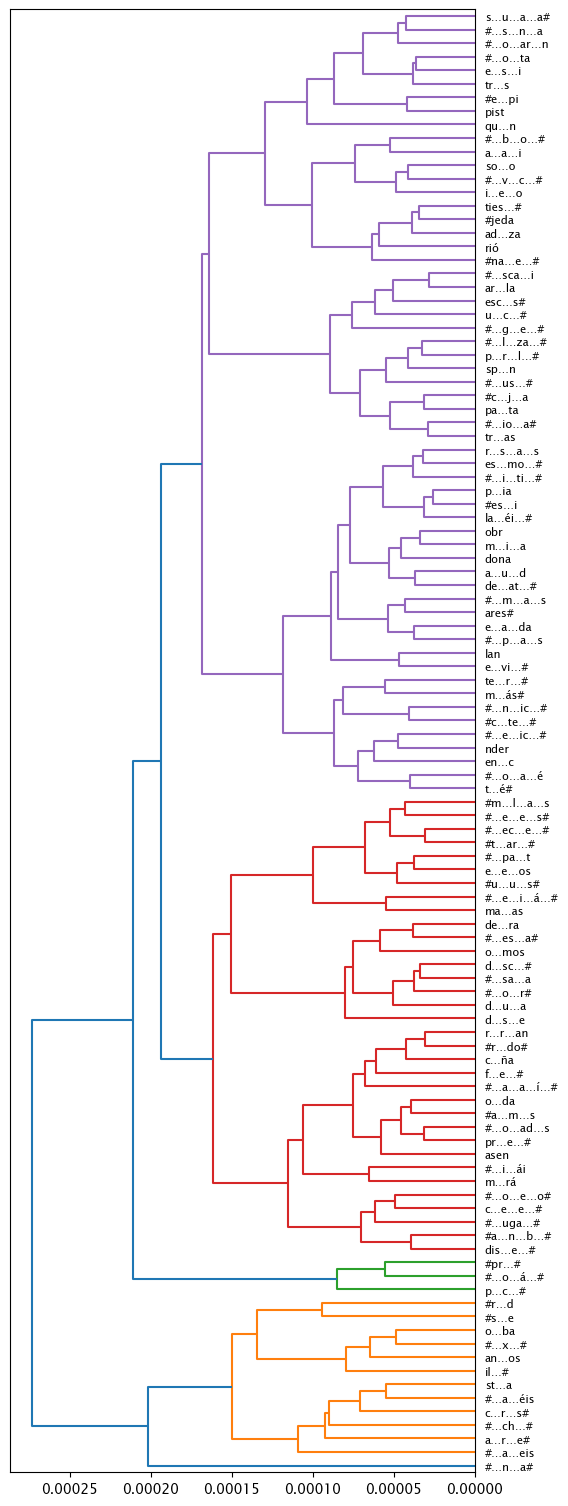

In [56]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp15, diction, term_type = term_type, n_topics= 15, lowest_density = 0.0002, max_length = n_for_ngram, min_length = 3, sampling_rate = hc_sampling_rate, gap_mark = gap_mark, use_CJK = False, check = False)

In [52]:
## HDP (n_topics = 45)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 45
hdp45 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data45 = pyLDAvis.gensim.prepare(hdp45, corpus, diction)
pyLDAvis.display(vis_data45)

In [53]:
## save LDAvis output as a html file
lang_dir_name = target_lang_dict[target_lang_key].split()[0]
#save_LDAvis = True
if save_LDAvis:
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data45, vis_output)

In [54]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp45.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    #hdp45_topics_out = f"results/terms-by-topics-raw/hdp{max_n_topics}_topics_raw.csv"
    hdp45_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp45_topics_out, header = False, index = None)
    print(f"saved: {hdp45_topics_out}")

In [55]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp45
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob
#
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: {len(probs.nonzero()[0])}")
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.001 * v…a + 0.0 * g…r + 0.0 * r…os + 0.0 * g…r…# + 0.0 * #…v…a + 0.0 * g…a…# + 0.0 * g…r…s + 0.0 * #…r…o…# + 0.0 * c…a# + 0.0 * c…l + 0.0 * r…os# + 0.0 * c…l…# + 0.0 * g…r…s# + 0.0 * #g…r…s + 0.0 * #…c…a# + 0.0 * #g…a + 0.0 * #g…a…# + 0.0 * e…o…a + 0.0 * #g…r + 0.0 * #…r…os
nonzero count: 299
	0.9987: #motejados#
	0.9986: #repellado#
	0.9986: #repelléis#
	0.9986: #moldearán#
	0.9986: #violarlos#
	0.9985: #crisolara#
	0.9985: #pompeados#
	0.9985: #ahornemos#
	0.9984: #poblaréis#
	0.9984: #gimoteado#
	0.9984: #repelosos#
	0.9984: #forrarnos#
	0.9984: #altivezas#
	0.9983: #nivelamos#
	0.9983: #gimoteáis#
topic_id 1: 0.0 * #b…a + 0.0 * #…e…o# + 0.0 * #…lo + 0.0 * lo + 0.0 * ap…# + 0.0 * r…e# + 0.0 * #ap + 0.0 * ap + 0.0 * #ap…# + 0.0 * #b + 0.0 * #b…# + 0.0 * #b…a…# + 0.0 * or…a + 0.0 * b…r…# + 0.0 * r…t…# + 0.0 * #…el…# + 0.0 * c…n…# + 0.0 * el…# + 0.0 * r…t + 0.0 * a…e…o
nonzero count: 226
	0.9988: #esputarse#
	0.9987: #acordonar#
	0.9987: #escorados#
	0.9986: #esterarte#
	

8743 rows remain after density filtering, discarding 91257 rows
8737 rows remain after size filtering, discarding 6 rows
87 rows remain after size filtering, discarding 8650 rows


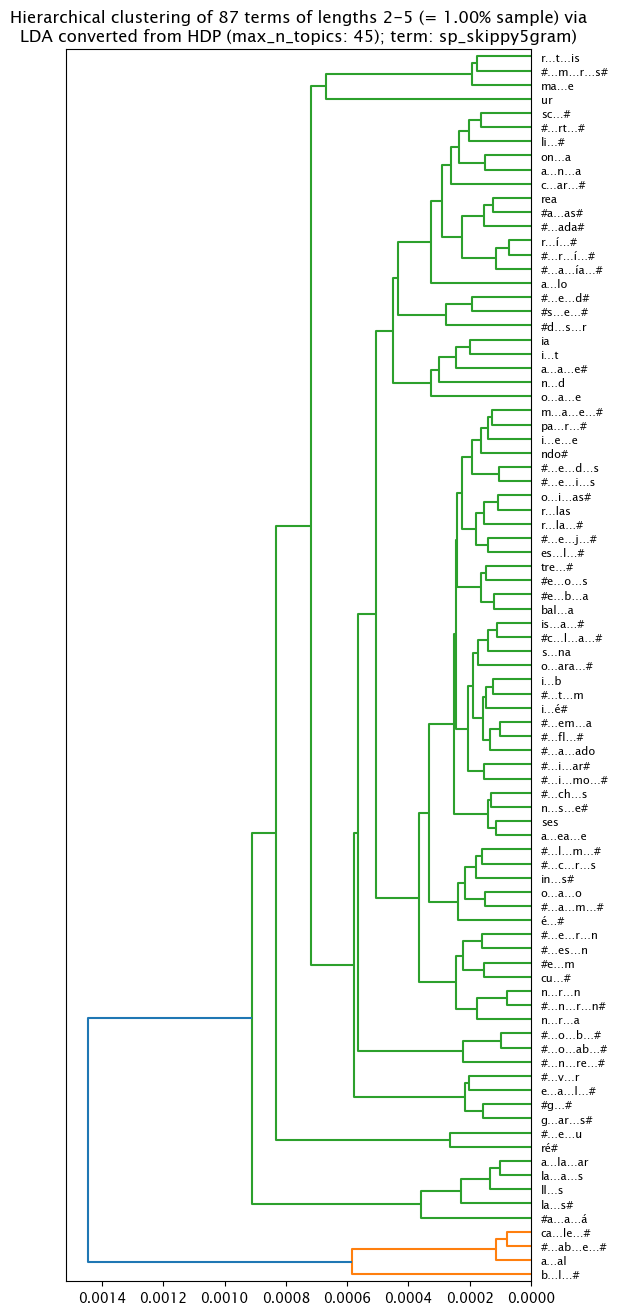

In [56]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
hc_clustering_terms_from_hdp(hdp45, diction, n_topics = 45, lowest_density = 0.0006, gap_mark = gap_mark, min_length = 2, sampling_rate = hc_sampling_rate, check = False)

In [57]:
## HDP (n_topics = 90)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 90
hdp90 = gensim.models.HdpModel(corpus, diction, T = max_n_topics,
                               random_state = 1)
vis_data90 = pyLDAvis.gensim.prepare(hdp90, corpus, diction)
pyLDAvis.display(vis_data90)

In [58]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data90, vis_output)

In [59]:
## save topic structures
if save_topic_structure:
    hdp_topics = hdp90.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }

    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp90_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp90_topics_out, header = False, index = None)
    print(f"saved: {hdp90_topics_out}")

In [60]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp90
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.001 * #…a…l + 0.001 * #…a…l…# + 0.0 * c…l + 0.0 * c…l…# + 0.0 * l…a…s + 0.0 * l…a…s# + 0.0 * a…á…# + 0.0 * #…l…a…s# + 0.0 * a…ás# + 0.0 * ca…l…# + 0.0 * #…l…a…s + 0.0 * ca…l + 0.0 * a…ás + 0.0 * u…r…s + 0.0 * u…r…s# + 0.0 * a…ar…s + 0.0 * a…ar…s# + 0.0 * v…a + 0.0 * g…r + 0.0 * #…l…a…ás
nonzero count:  262
	0.9989: #allanarás#
	0.9987: #revenaste#
	0.9983: #guardaros#
	0.9982: #edulcores#
	0.9981: #noruestee#
	0.9979: #evocarla#
	0.9979: #borneada#
	0.9976: #escupida#
	0.9976: #caballeó#
	0.9975: #debutaré#
	0.9974: #ungieres#
	0.9945: #revote#
	0.9920: #escudarse#
	0.9902: #quina#
	0.9888: #apelo#
topic_id 1: 0.001 * #t…a + 0.001 * #t…# + 0.001 * #t + 0.001 * #t…a…# + 0.0 * t…e…# + 0.0 * #t…e + 0.0 * t…a# + 0.0 * #t…e…# + 0.0 * c…a# + 0.0 * #…r…ar + 0.0 * #t…r + 0.0 * #t…a# + 0.0 * #t…r…# + 0.0 * #…r…ar…# + 0.0 * t…a…a + 0.0 * ce + 0.0 * t…á + 0.0 * ce…# + 0.0 * #…ce + 0.0 * t…á…#
nonzero count:  229
	0.9989: #tornarlas#
	0.9988: #tornarlos#
	0.9987: #tromparas#
	0.9987:

7139 rows remain after density filtering, discarding 92861 rows
7133 rows remain after size filtering, discarding 6 rows
71 rows remain after size filtering, discarding 7062 rows


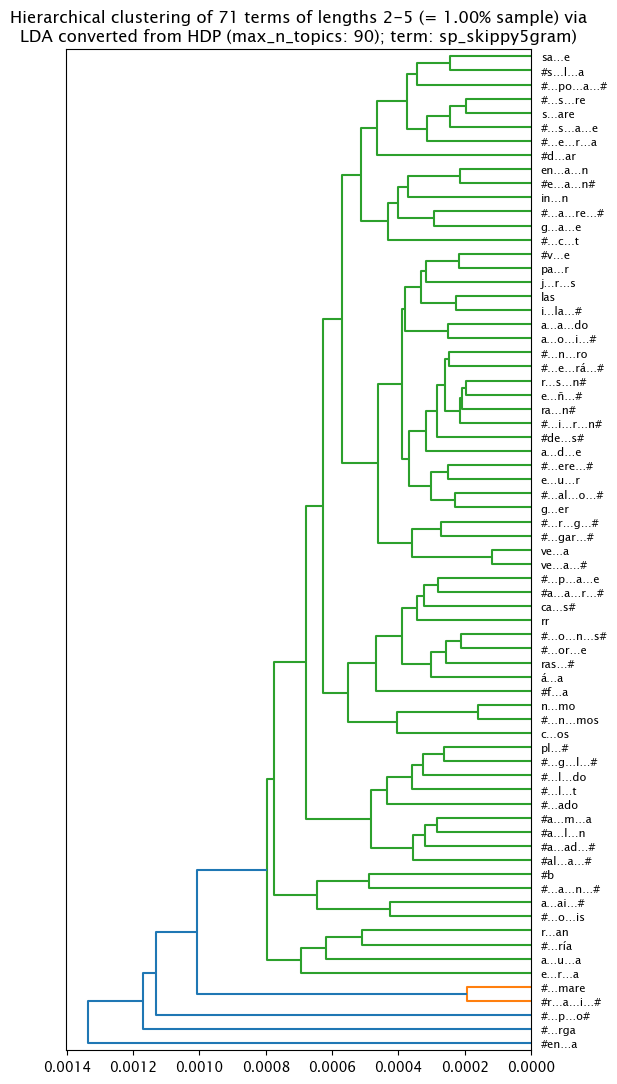

In [61]:
## term の階層クラスタリング: max_n_topics, term の値に拠ってparameters の最適値は異なる
hc_clustering_terms_from_hdp(hdp90, diction, n_topics = 90, gap_mark = gap_mark, lowest_density = 0.0012, min_length = 2, sampling_rate = hc_sampling_rate, check = False)